In [1]:
#!pip install --upgrade transformers

In [2]:
#!pip install wandb


In [3]:
#!wandb login


In [1]:
!rm -rf /kaggle/working/*

In [4]:
from torch import nn


class MisogynyCls(nn.Module):
    def __init__(self, num_linear_layers, single_task_mode=True, task_a_out=1, task_b_out=4, input_dim=1024, hidden_dim=512, drop_value=0.2):
        super().__init__()
        self.single_task_mode=single_task_mode
        self.head_task_a = nn.Linear(hidden_dim, task_a_out)
        if not self.single_task_mode:
            self.head_task_b = nn.Linear(hidden_dim, task_b_out)
        self.sigmoid = nn.Sigmoid()


        self.layers = nn.ModuleList()

        for i in range(num_linear_layers):
            if i == 0:
                self.layers.append(nn.Linear(input_dim, hidden_dim))
            else:
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
                
            self.layers.append(nn.Dropout(drop_value))
            self.layers.append(nn.ReLU())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        pred_taskA = self.sigmoid(self.head_task_a(x))
        if not self.single_task_mode:
            pred_taskB = self.sigmoid(self.head_task_b(x))
            return pred_taskA.squeeze(1), pred_taskB
        else:
            return pred_taskA.squeeze(1)

## tsv/csv to json

In [5]:
import csv
import json
import os

images_path = "/kaggle/input/dataset-wow/MAMI DATASET/MAMI DATASET/training/TRAINING"

file_and_dest = [('/kaggle/input/dataset-wow/train_image_text.tsv','/kaggle/working/train_image_text.json'),
                    ('/kaggle/input/dataset-wow/test_image_text.tsv','/kaggle/working/test_image_text.json')]


for file in file_and_dest: 
    data = []

    with open(file[0], newline='', encoding='utf-8') as tsvfile:
        reader = csv.DictReader(tsvfile, delimiter='\t')
        
        for row in reader:
            data.append(row)
                
    if not os.path.exists(file[1]):
        with open(file[1], 'w', encoding='utf-8') as jsonfile:
            json.dump([], jsonfile, ensure_ascii=False, indent=4)
        print(f"File JSON vuoto creato come {file[1]}")

        with open(file[1], 'w', encoding='utf-8') as jsonfile:
            json.dump(data, jsonfile, ensure_ascii=False, indent=4)

        print(f"File JSON salvato come {file[1]}")



In [5]:
'''
import csv
import json
import os

images_path = "/kaggle/input/dataset-wow/MAMI DATASET/MAMI DATASET/training/TRAINING"

file_source = '/kaggle/input/dataset-wow/train_image_text.tsv'
file_train = '/kaggle/working/train_image_text.json'
file_test = '/kaggle/working/test_image_text.json'
data = []

with open(file_source, newline='', encoding='utf-8') as tsvfile:
    reader = csv.DictReader(tsvfile, delimiter='\t')
    

    for row in reader:
        file_path = os.path.join(images_path, row["file_name"])

        if os.path.exists(file_path):
            data.append(row)
    
    split = int(len(data)*0.8)

    with open(file_train, 'w', encoding='utf-8') as jsonfile:
        json.dump([], jsonfile, ensure_ascii=False, indent=4)
    print(f"File JSON vuoto creato come {file_train}")

    with open(file_test, 'w', encoding='utf-8') as jsonfile:
        json.dump([], jsonfile, ensure_ascii=False, indent=4)
    print(f"File JSON vuoto creato come {file_test}")
    
    with open(file_train, 'w', encoding='utf-8') as jsonfile:
        json.dump(data[:split], jsonfile, ensure_ascii=False, indent=4)
    print(f"File JSON salvato come {file_train}")
        
    with open(file_test, 'w', encoding='utf-8') as jsonfile:
        json.dump(data[split:], jsonfile, ensure_ascii=False, indent=4)
    print(f"File JSON salvato come {file_test}")
'''

'\nimport csv\nimport json\nimport os\n\nimages_path = "/kaggle/input/dataset-wow/MAMI DATASET/MAMI DATASET/training/TRAINING"\n\nfile_source = \'/kaggle/input/dataset-wow/train_image_text.tsv\'\nfile_train = \'/kaggle/working/train_image_text.json\'\nfile_test = \'/kaggle/working/test_image_text.json\'\ndata = []\n\nwith open(file_source, newline=\'\', encoding=\'utf-8\') as tsvfile:\n    reader = csv.DictReader(tsvfile, delimiter=\'\t\')\n    \n\n    for row in reader:\n        file_path = os.path.join(images_path, row["file_name"])\n\n        if os.path.exists(file_path):\n            data.append(row)\n    \n    split = int(len(data)*0.8)\n\n    with open(file_train, \'w\', encoding=\'utf-8\') as jsonfile:\n        json.dump([], jsonfile, ensure_ascii=False, indent=4)\n    print(f"File JSON vuoto creato come {file_train}")\n\n    with open(file_test, \'w\', encoding=\'utf-8\') as jsonfile:\n        json.dump([], jsonfile, ensure_ascii=False, indent=4)\n    print(f"File JSON vuoto cr

## Multimodal Dataset definition

In [6]:
from torch.utils.data import Dataset
import os
import wandb

class MultimodalDataset(Dataset): # Dataset for handling multimodal data
    def __init__(self, images_dir, json_file_path): # dir_path -> directory path where images are stored / json_file_path -> file path for metadata (including labels)   
        file_paths, text_list, labels_misogyny, shaming_label_list, stereotype_label_list, objectification_label_list, violence_label_list = load_json_file(json_file_path)
   
        self.file_paths = file_paths
        self.images_dir = images_dir
        self.text_list = text_list
        self.labels_misogyny = labels_misogyny
        self.shaming_label_list = shaming_label_list
        self.stereotype_label_list = stereotype_label_list
        self.objectification_label_list = objectification_label_list
        self.violence_label_list = violence_label_list
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        return self.file_paths[idx], self.text_list[idx], self.labels_misogyny[idx], self.shaming_label_list[idx], self.stereotype_label_list[idx], self.objectification_label_list[idx], self.violence_label_list[idx]
    
def load_json_file(json_file_path):
    with open(json_file_path,"r") as f:
        data = json.load(f)
        text_list = [] # list of the text related to each image
        image_list = [] # list of images path
        labels_misogyny = [] # list of TASK A labels (misogyny classification)

        ### list of TASK B labels ###
        shaming_label_list = [] 
        stereotype_label_list = []
        objectification_label_list = []
        violence_label_list = []


        for item in tqdm(data): 
            image_list.append(item['file_name'])
            text_list.append(item["text"])
            labels_misogyny.append(float(item["label"]))
            shaming_label_list.append(float(item["shaming"]))
            stereotype_label_list.append(float(item["stereotype"]))
            objectification_label_list.append(float(item["objectification"]))
            violence_label_list.append(float(item["violence"]))

        #print(f"{type(labels_misogyny)}")
        return image_list, text_list, torch.tensor(labels_misogyny, dtype=torch.float32), torch.tensor(shaming_label_list, dtype=torch.float32), torch.tensor(stereotype_label_list, dtype=torch.float32), torch.tensor(objectification_label_list, dtype=torch.float32), torch.tensor(violence_label_list, dtype=torch.float32)
    
def accuracy(preds, labels, thresh):
    num_samples = labels.shape[0]
    preds = preds > thresh
    matching_rows = torch.eq(labels.bool(), preds)
    
    # in case we're dealing with the prediction of task B/task A (they've different number of dimensions)
    num_correct = matching_rows.all(dim=1).sum().item() if preds.ndim!=1 else matching_rows.sum().item()
    return 100*(num_correct/num_samples)

## LOADING THE DATASET AND TRAINING THE NETWORK

In [7]:
### import torch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from PIL import Image # per debug
import os
import json
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim
import wandb



class Trainer():
    def __init__(self, 
                model,     
                train_images_dir,
                test_image_dir,
                json_train_path,
                json_test_path,
                single_task_mode=True,
                train_data_split=0.8,
                batch_size=256, 
                lr=0.001, 
                num_epochs=15,
                threshold=0.5,
                weight_taskA=0.7,
                weight_taskB=0.3):
        
        # Check if CUDA is available
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Training on: {self.device}")
        
        # Loading the Dataset
        self.train_images_dir = train_images_dir
        self.test_image_dir = test_image_dir
        self.num_epochs = num_epochs
        self.threshold = threshold
        self.weight_taskA = weight_taskA
        self.single_task_mode=single_task_mode
        if not self.single_task_mode:
            self.weight_taskB = weight_taskB
        
        train_data = MultimodalDataset(train_images_dir, json_train_path)
        test_data = MultimodalDataset(test_image_dir, json_test_path)
        
    
        self.train_dataloader = DataLoader(train_data, batch_size, shuffle=True, pin_memory=True)
        self.test_dataloader = DataLoader(test_data, batch_size, shuffle=True, pin_memory=True)

        # Defining the Model
        self.classifier = model.to(self.device)
        self.optimizer = optim.Adam(self.classifier.parameters(), lr)
        self.loss_taskA = F.binary_cross_entropy 
        if not self.single_task_mode:
            self.loss_taskB = F.binary_cross_entropy

        # Pretrained CLIP loading...
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", device_map='cuda')
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
        
    def get_random_test_sample(self):
        
        batch = next(iter(self.test_dataloader))
        print(f"batch:{len(batch)}")
        images,images_text,_,_,_,_,_ = batch
        image_list = [Image.open(f"{os.path.join(self.test_image_dir, img)}") for img in images] 
        print(f"images:{image_list}")
        return image_list, images_text
        
    def train_model(self):
        
        print(f"training on samples:{test_data.__len__()}")
        print(f"testing on samples:{test_data.__len__()}")
        if not self.single_task_mode:
            print(f"training model in single task mode: Misoginy Identification")
        else:
            print(f"training model in dual task mode: Misoginy Identification and Misoginy Classification")
        
        for epoch in range(self.num_epochs):
            print(f'Epoch [{epoch+1}/{self.num_epochs}]')
            if not self.single_task_mode:
                train_loss_list, test_loss_list, train_acc_taskA_list, train_acc_taskB_list,  test_acc_taskA_list, test_acc_taskB_list= self.train_epoch()
            else:
                train_loss_list, test_loss_list, train_acc_taskA_list, test_acc_taskA_list= self.train_epoch()
            print(f'Average Train Loss: {sum(train_loss_list) / len(train_loss_list): .4f}, Average Test Loss: {sum(test_loss_list) / len(test_loss_list): .4f}')
            print(f'Average Accuracy Train (task A): {sum(train_acc_taskA_list) / len(train_acc_taskA_list): .4f}%, Average Accuracy Test (task A): {sum(test_acc_taskA_list) / len(test_acc_taskA_list): .4f}%')
            if not self.single_task_mode:
                print(f'Average Accuracy Train (task B): {sum(train_acc_taskB_list) / len(train_acc_taskB_list): .4f}%, Average Accuracy Test (task B): {sum(test_acc_taskB_list) / len(test_acc_taskB_list): .4f}%')

            model_path = '/kaggle/working/model_' + str(epoch+1) + '.pth'
            torch.save(self.classifier.state_dict(), model_path);
            
            

    def train_epoch(self):
        train_loss_list = []
        test_loss_list = []
        train_acc_taskA_list = []
        train_acc_taskB_list = []
        test_acc_taskA_list = []
        test_acc_taskB_list = []
        
        for batch in tqdm(self.train_dataloader):
            self.optimizer.zero_grad() # ZEROING OUT THE GRADIENTS
            self.classifier.train() # TRAINING MODE
            
            # CREATING THE CLIP EMBEDDINGS
            image_list, text_list, labels_misogyny, shaming_labels, stereotype_labels, objectification_labels, violence_labels = batch
            
            image_list = [Image.open(f"{os.path.join(self.train_images_dir, img)}") for img in image_list] # per poterlo usare poi con CLIP
            labels_misogyny = labels_misogyny.to(self.device)
            labels_taskB = torch.stack([shaming_labels, stereotype_labels, objectification_labels, violence_labels],  dim=1).to(self.device)

            clip_inputs = self.clip_processor(text=text_list, images=image_list, return_tensors="pt", padding=True, truncation=True)
            clip_inputs['input_ids'] = clip_inputs['input_ids'].to(self.device)
            clip_inputs['attention_mask'] = clip_inputs['attention_mask'].to(self.device)
            clip_inputs['pixel_values'] = clip_inputs['pixel_values'].to(self.device)
    
            clip_outputs = self.clip_model(**clip_inputs)
            model_input = torch.cat([clip_outputs['text_embeds'], clip_outputs['image_embeds']], dim=1).to(self.device)
    
    
            if not self.single_task_mode:
                pred_taskA, pred_taskB = self.classifier(model_input)
            else:
                pred_taskA = self.classifier(model_input)

            loss_A = self.loss_taskA(pred_taskA, labels_misogyny)
            if not self.single_task_mode:
                loss_B = self.loss_taskB(pred_taskB, labels_taskB, reduction='mean')
                loss = (self.weight_taskA * loss_A) + (self.weight_taskB * loss_B)
            else:
                loss= loss_A
            train_loss_list.append(loss)
            
            loss.backward()
            self.optimizer.step()

            accuracy_taskA = accuracy(pred_taskA, labels_misogyny, self.threshold)
            if not self.single_task_mode:
                accuracy_taskB = accuracy(pred_taskB, labels_taskB, self.threshold)
            
            train_acc_taskA_list.append(accuracy_taskA)
            if not self.single_task_mode:
                train_acc_taskB_list.append(accuracy_taskB)
        
        
        with torch.no_grad():
            self.classifier.eval()

            for batch in tqdm(self.test_dataloader):
                # CREATING THE CLIP EMBEDDINGS
                image_list, text_list, labels_misogyny, shaming_labels, stereotype_labels, objectification_labels, violence_labels = batch

                image_list = [Image.open(f"{os.path.join(self.test_image_dir, img)}") for img in image_list] # per poterlo usare poi con CLIP
                labels_misogyny = labels_misogyny.to(self.device)
                labels_taskB = torch.stack([shaming_labels, stereotype_labels, objectification_labels, violence_labels],  dim=1).to(self.device)

                clip_inputs = self.clip_processor(text=text_list, images=image_list, return_tensors="pt", padding=True, truncation=True)
                clip_inputs['input_ids'] = clip_inputs['input_ids'].to(self.device)
                clip_inputs['attention_mask'] = clip_inputs['attention_mask'].to(self.device)
                clip_inputs['pixel_values'] = clip_inputs['pixel_values'].to(self.device)

                clip_outputs = self.clip_model(**clip_inputs)
                model_input = torch.cat([clip_outputs['text_embeds'], clip_outputs['image_embeds']], dim=1).to(self.device)
                
                if not self.single_task_mode:
                    pred_taskA, pred_taskB = self.classifier(model_input)
                else:
                    pred_taskA = self.classifier(model_input)

                loss_A = self.loss_taskA(pred_taskA, labels_misogyny)
                if not self.single_task_mode:
                    loss_B = self.loss_taskB(pred_taskB, labels_taskB, reduction='mean')
                    loss = (self.weight_taskA * loss_A) + (self.weight_taskB * loss_B)
                else:
                    loss=loss_A
                test_loss_list.append(loss)

                accuracy_taskA = accuracy(pred_taskA, labels_misogyny, self.threshold)
                if not self.single_task_mode:
                    accuracy_taskB = accuracy(pred_taskB, labels_taskB, self.threshold)

                test_acc_taskA_list.append(accuracy_taskA)
                
                if not self.single_task_mode:
                    test_acc_taskB_list.append(accuracy_taskB)

        if not self.single_task_mode:
            return train_loss_list, test_loss_list, train_acc_taskA_list, train_acc_taskB_list, test_acc_taskA_list, test_acc_taskB_list
        else:
            return train_loss_list, test_loss_list, train_acc_taskA_list,  test_acc_taskA_list, 
            

In [19]:
model = MisogynyCls(5)

In [20]:
model_trainer = Trainer(model, # model 
                        "/kaggle/input/dataset-wow/MAMI DATASET/MAMI DATASET/training/TRAINING",# train_images_dir
                        "/kaggle/input/dataset-wow/MAMI DATASET/MAMI DATASET/test", #test_images_dir
                        "/kaggle/working/train_image_text.json",
                        "/kaggle/working/test_image_text.json",
                        batch_size=64,
                        weight_taskA=1,
                        weight_taskB=1) # json_file as data source


Training on: cuda:0


100%|██████████| 1000/1000 [00:00<00:00, 463510.22it/s]


In [ ]:

model_trainer.train_model()

Prepare Data for MM-SHAP

In [21]:
test_images,text_images=model_trainer.get_random_test_sample()

batch:7
images:[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x427 at 0x79C3F80D9BA0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x553 at 0x79C3F80D98A0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x443 at 0x79C3F80D9D20>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=533x640 at 0x79C3F80DB190>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=517x640 at 0x79C3F80DA590>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x478 at 0x79C3F80DB0D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x345 at 0x79C3F80DB4C0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=503x640 at 0x79C3F80DB370>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=479x640 at 0x79C3F80D9390>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x442 at 0x79C3F80D93F0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x632 at 0x79C3F80D9330>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x479 at 0x79C

# Pre-Processing Step for image (and text) to be explained with MM-SHAP 

In [22]:
text_images[0]

"imgflip.com HER: HE'S PROBABLY THINKING ABOUT OTHER WOMEN ME: YUP"

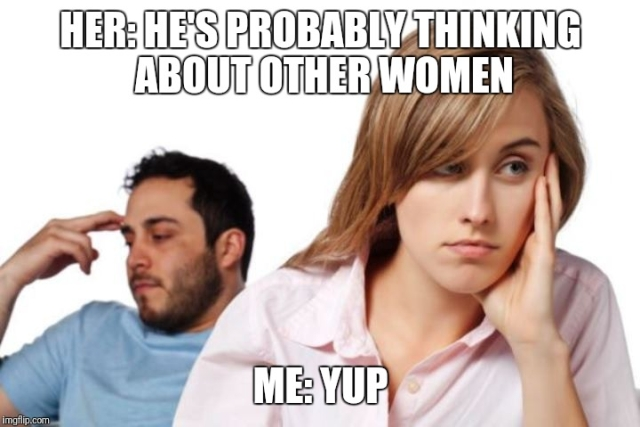

In [23]:
test_images[0]

In [24]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [27]:
inputs = processor(text=text_images[0], images=test_images[0], return_tensors="pt", padding=True)

In [29]:
clip_model_prediction = clip_model(**inputs).logits_per_image[0,0].item()
print(clip_model_prediction)

32.52919387817383


In [32]:
import math
import numpy as np

nb_text_tokens = inputs.input_ids.shape[1]
print(f"nb_next_tokens: {nb_text_tokens}")
p = int(math.ceil(np.sqrt(nb_text_tokens)))
patch_size = 224 // p
print(f"patch_size: {patch_size}")
image_token_ids = torch.tensor(range(1, p**2+1)).unsqueeze(0)
print(f"image_tokens_ids: {image_token_ids}")

nb_next_tokens: 19
patch_size: 44
image_tokens_ids: tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25]])


In [40]:
# sample to be explained obtained through concatenation of text and image embeddings
X = torch.cat((inputs.input_ids, image_token_ids), 1).unsqueeze(1)
print(f"sample dim:{X.shape}") # 19 text tokens+ 25 image tokens ----> 44 tokens

sample dim:torch.Size([1, 1, 44])


In [41]:
def get_model_prediction(x):
    """
    Shap relevant function.
    1. Mask the image pixel according to the specified patches to mask from the custom masker.
    2. Predict the model output for all combinations of masked image and tokens. This is then further passed to the shap libary.
    """
    with torch.no_grad():
        # split up the input_ids and the image_token_ids from x (containing both appended)
        input_ids = torch.tensor(x[:, :inputs.input_ids.shape[1]])
        masked_image_token_ids = torch.tensor(x[:, inputs.input_ids.shape[1]:])

        # select / mask features and normalized boxes from masked_image_token_ids
        result = np.zeros(input_ids.shape[0])

        row_cols = 224 // patch_size # 224 / 32 = 7

        # call the model for each "new image" generated with masked features
        for i in range(input_ids.shape[0]):
            # here the actual masking of the image is happening. The custom masker only specified which patches to mask, but no actual masking has happened
            masked_inputs = copy.deepcopy(inputs)  # initialize the thing
            masked_inputs['input_ids'] = input_ids[i].unsqueeze(0)

            # pathify the image
            # torch.Size([1, 3, 224, 224]) image size CLIP
            for k in range(masked_image_token_ids[i].shape[0]):
                if masked_image_token_ids[i][k] == 0:  # should be zero
                    m = k // row_cols
                    n = k % row_cols
                    masked_inputs["pixel_values"][:, :, m *
                        patch_size:(m+1)*patch_size, n*patch_size:(n+1)*patch_size] = 0 # torch.rand(3, patch_size, patch_size)  # np.random.rand()
            
            outputs = model(**masked_inputs)
            # CLIP does not work with probabilities, because these are computed with softmax among choices (which I do not have here)
            # this is the image-text similarity score
            result[i] = outputs.logits_per_image
    return result


In [44]:
def custom_masker(mask, x):
    """
    Shap relevant function.
    It gets a mask from the shap library with truth values about which image and text tokens to mask (False) and which not (True).
    It defines how to mask the text tokens and masks the text tokens. So far, we don't mask the image, but have only defined which image tokens to mask. The image tokens masking happens in get_model_prediction().
    """
    masked_X = x.clone()
    mask = torch.tensor(mask).unsqueeze(0)
    masked_X[~mask] = 0  # ~mask !!! to zero
    # never mask out CLS and SEP tokens (makes no sense for the model to work without them)
    masked_X[0, 0] = 49406
    masked_X[0, nb_text_tokens-1] = 49407
    return masked_X

In [47]:
import shap 

explainer = shap.Explainer(get_model_prediction, custom_masker, silent=True)
                    
shap_values = explainer(X)

NameError: name 'copy' is not defined